# Time Series Forecasting with Keras in Python

## About dataset
One can use this dataset to learn and implement Univariate Time Series

### Preface:
To understand how to read, plot and work with time series data
Basic Manipulation of time series data
Many more…

### Data Dictionary:
Date => date when observation was taken

count => number on given date

### Aim:
Use this data and forecast count

In [4]:
# import dataset 
import pandas as pd

# Read the CSV file and create DataFrame
data = pd.read_csv('date_count.csv',index_col=None)
df = pd.DataFrame(data)

In [5]:
df.head()

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2


In [6]:
df.tail()

,Date,count
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214
577,2014-03-25,236


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    578 non-null    object
 1   count   578 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.2+ KB


# Dickey-Fuller Test 

In [8]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
result = adfuller(df['count'])
print(result)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

(-0.05661110288283321, 0.953592387239636, 19, 558, {'1%': -3.4421235439968862, '5%': -2.866733577794069, '10%': -2.569536010842615}, 4882.884852537056)
ADF Statistic: -0.05661110288283321
p-value: 0.953592387239636
Critical Values:
1%: -3.4421235439968862
5%: -2.866733577794069
10%: -2.569536010842615


In [9]:
df['rolling_mean'] = df['count'].rolling(window=3).mean()

df['rolling_Std'] = df['count'].rolling(window=3).std()

df

,Date,count,rolling_mean,rolling_Std
0,2012-08-25,3,NaN,NaN
1,2012-08-26,3,NaN,NaN
2,2012-08-27,2,2.666667,0.577350
3,2012-08-28,2,2.333333,0.577350
4,2012-08-29,2,2.000000,0.000000
...,...,...,...,...
573,2014-03-21,149,155.000000,34.394767
574,2014-03-22,129,134.000000,13.228757
575,2014-03-23,119,132.333333,15.275252
576,2014-03-24,214,154.000000,52.201533


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='Date', ylabel='count'>

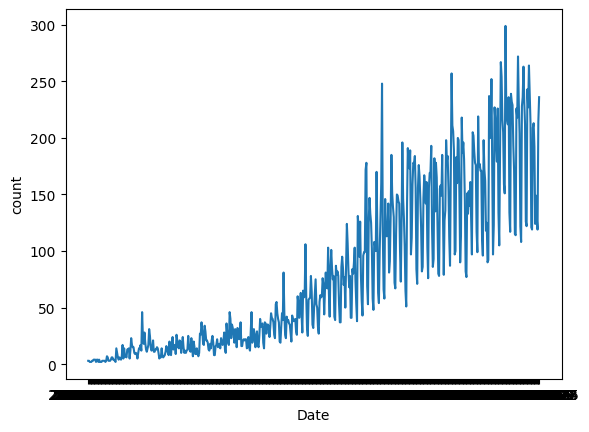

In [11]:
plt.figure()
sns.lineplot(x='Date', y = 'count',  data= df)


<Figure size 2000x500 with 0 Axes>

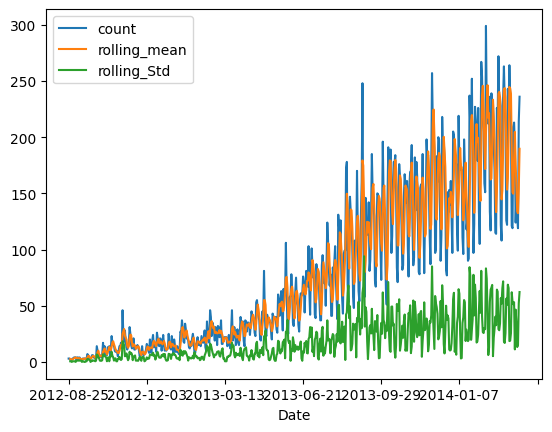

In [9]:
plt.figure(figsize=(20,5))
df.plot('Date',['count','rolling_mean','rolling_Std'] , kind='line')
plt.show()

In [10]:
df = df[['Date','count']]
df

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2
...,...,...
573,2014-03-21,149
574,2014-03-22,129
575,2014-03-23,119
576,2014-03-24,214


# Model 1: DNN
DNN(Deep Neural Network): DNN is a type of neural network with multiple hidden layers that can learn hierarchical representations of data. 

### Step 1: Data Preprocessing

In [11]:
import numpy as np

# Function to convert data array to a matrix format
def convert2matrix(data_arr, look_back):
    data_arr = data_arr[:, 1].astype('int')  # Extract the Date column and convert it to int type
    X, Y = [], []
    for i in range(len(data_arr)-look_back):
        d = i+look_back
        X.append(data_arr[i:d])  # Append the sequence of look_back values as input
        Y.append(data_arr[d])  # Append the next value as output
    return np.array(X), np.array(Y)

In [12]:
# Split data set into testing dataset and train dataset
train_size = 300
train, test = df.values[0:train_size, :], df.values[train_size:len(df.values), :]

# Setup look_back window
look_back = 30

# Convert dataset into the right shape to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

### Step 2: Define Neural Network Shape and Compile Model

In [13]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error 

def model_dnn(look_back):
    model = Sequential()
    model.add(Dense(units=32, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### Step 3: Fit Model

In [31]:
model = model_dnn(look_back)

history = model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX, testY),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], shuffle=False)  #EarlyStopping monitors the model's performance during training, stopping training if the validation loss does not drop over a certain period of time.

Epoch 1/100
9/9 [==============================] - 1s 17ms/step - loss: 1466.8047 - mse: 1466.8047 - mae: 34.0863 - val_loss: 28819.7578 - val_mse: 28819.7578 - val_mae: 162.2914
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 872.1882 - mse: 872.1882 - mae: 25.7083 - val_loss: 20588.0078 - val_mse: 20588.0078 - val_mae: 136.2766
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 659.3182 - mse: 659.3182 - mae: 21.9817 - val_loss: 15551.6934 - val_mse: 15551.6934 - val_mae: 117.1573
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 473.5822 - mse: 473.5822 - mae: 18.2296 - val_loss: 10266.9131 - val_mse: 10266.9131 - val_mae: 93.0581
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 307.1782 - mse: 307.1782 - mae: 14.0330 - val_loss: 5671.9482 - val_mse: 5671.9482 - val_mae: 65.6851
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 178.5344 - mse: 178.5344 - mae: 9.7772 - val_loss:

### Step 4: Model Evaluation

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def model_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()

Train Root Mean Squared Error (RMSE): 7.35; Train Mean Absolute Error (MAE): 5.21
Test Root Mean Squared Error (RMSE): 28.68; Test Mean Absolute Error (MAE): 22.07


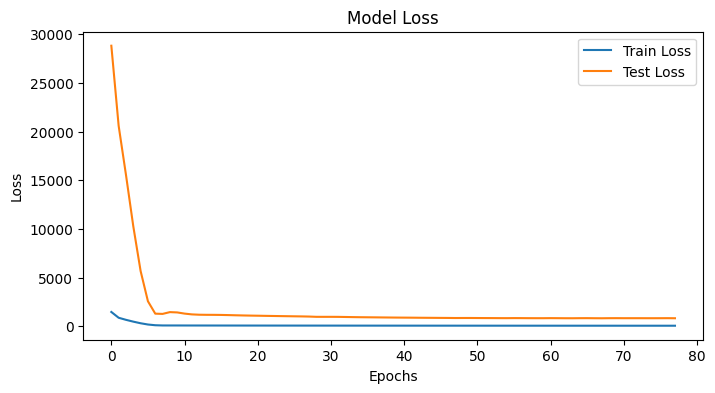

In [33]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error (RMSE): %.2f; Train Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(train_score[1]), train_score[2]))

test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error (RMSE): %.2f; Test Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(test_score[1]), test_score[2]))

model_loss(history)

### Step 5. Visualizing Prediction

In [34]:
test_predict = model.predict(testX)

def prediction_plot(testY, test_predict):
    len_prediction = list(range(len(testY)))
    plt.figure(figsize=(8, 4))
    plt.plot(len_prediction, testY[:len(len_prediction)], marker='.', label="Actual")
    plt.plot(len_prediction, test_predict[:len(len_prediction)], 'r', label="Prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time Step', size=15)
    plt.legend(fontsize=15)
    plt.show()

8/8 [==============================] - 0s 1ms/step


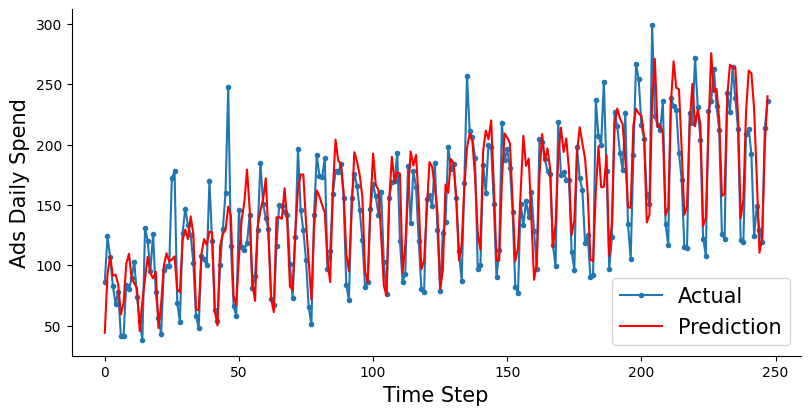

In [35]:
prediction_plot(testY, test_predict)

# Model 2: RNN
RNN(Recurrent Neural Network): RNN is designed for sequential data analysis and can capture temporal dependencies. 

### Step 1: Data Preprocessing

In [36]:
def convert2matrix(data_arr, look_back):
    X, Y = [], []
    for i in range(len(data_arr)-look_back):
        d = i+look_back
        X.append(data_arr[i:d])
        Y.append(data_arr[d])
    return np.array(X), np.array(Y)

In [37]:
train_size = 300
train, test = df.values[0:train_size, 1].astype(float), df.values[train_size:len(df.values), 1].astype(float)
look_back = 30  #create window size as look_back=30
test = np.append(test, np.repeat(test[-1], look_back))
train = np.append(train, np.repeat(train[-1], look_back))
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

# reshape input to be [samples, window size, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Step 2: Define Neural Network Shape and Compile Model

In [71]:
from keras.layers import SimpleRNN
def model_rnn(look_back):
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(look_back, 1), activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### Step 3: Fit Model

In [81]:
model = model_rnn(look_back)

history = model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=1, validation_data=(testX, testY),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], shuffle=False)

Epoch 1/100
10/10 [==============================] - 3s 72ms/step - loss: 926.7146 - mse: 926.7146 - mae: 25.5781 - val_loss: 20703.7773 - val_mse: 20703.7773 - val_mae: 134.2188
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 690.7534 - mse: 690.7534 - mae: 21.8314 - val_loss: 14859.1035 - val_mse: 14859.1035 - val_mae: 111.9817
Epoch 3/100
10/10 [==============================] - 0s 19ms/step - loss: 396.6412 - mse: 396.6412 - mae: 16.1498 - val_loss: 6225.0337 - val_mse: 6225.0337 - val_mae: 66.7488
Epoch 4/100
10/10 [==============================] - 0s 19ms/step - loss: 111.9535 - mse: 111.9535 - mae: 7.5820 - val_loss: 1655.1388 - val_mse: 1655.1388 - val_mae: 32.3346
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 173.9368 - mse: 173.9368 - mae: 9.2342 - val_loss: 3446.1426 - val_mse: 3446.1426 - val_mae: 48.6924
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 86.1683 - mse: 86.1683 - mae: 6.2578 - val_

### Step 4: Model Evaluation

9/9 [==============================] - 0s 981us/step
Train Root Mean Squared Error (RMSE): 7.67; Train Mean Absolute Error (MAE): 5.49
Test Root Mean Squared Error (RMSE): 29.08; Test Mean Absolute Error (MAE): 22.34


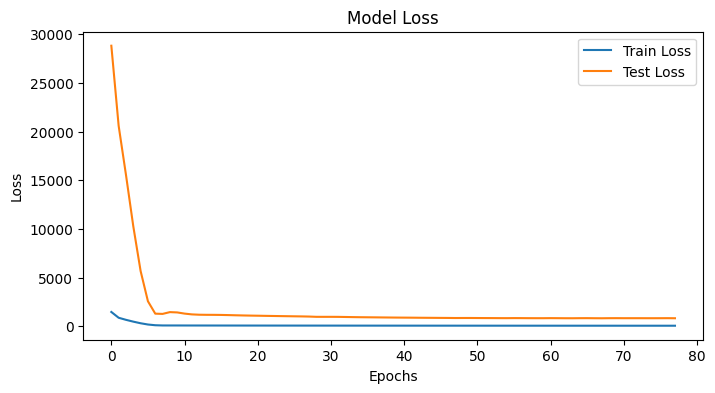

In [38]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

print('Train Root Mean Squared Error (RMSE): %.2f; Train Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(trainY, train_predict[:, 0])), mean_absolute_error(trainY, train_predict[:, 0])))
print('Test Root Mean Squared Error (RMSE): %.2f; Test Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(testY, test_predict[:, 0])), mean_absolute_error(testY, test_predict[:, 0])))

model_loss(history)

### Step 5. Visualizing Prediction

In [39]:
def prediction_plot(testY, test_predict, look_back):
    len_prediction = [x for x in range(len(testY)-look_back)]
    len_prediction = [int(x) for x in len_prediction]  
    plt.plot(len_prediction, testY[:len(len_prediction)], marker='.', label="Actual")
    plt.plot(len_prediction, test_predict[:len(len_prediction)], 'r', label="Prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time Step', size=15)
    plt.legend(fontsize=15)
    plt.show()

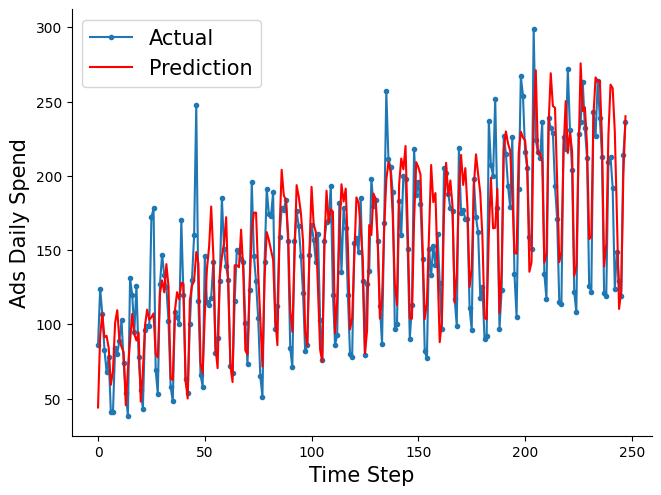

In [40]:
prediction_plot(testY, test_predict, look_back)

# Model 3: LSTM
LSTM (Long Short-Term Memory): LSTM is a specialized type of RNN that excels in capturing long-term dependencies by introducing memory cells and gating mechanisms.

### Step 1: Data Preprocessing

In [62]:
def convert2matrix(data_arr, look_back):
    X, Y = [], []
    for i in range(len(data_arr) - look_back):
        d = i + look_back
        X.append(data_arr[i:d, ])
        Y.append(data_arr[d, ])
    return np.array(X), np.array(Y)

In [63]:
from sklearn.preprocessing import MinMaxScaler
# create numpy.ndarray
df_arr = df.values
df_arr = df_arr[:, 1] 
df_arr = df_arr.astype('float32')
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0, 1)) #LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [64]:
train_size = 300
test_size = len(df_arr) - train_size
train, test = df_arr[0:train_size, :], df_arr[train_size:len(df_arr), :]
look_back = 30
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, trainX.shape[2]))

### Step 2: Define Neural Network Shape and Compile Model

In [65]:
from keras.layers import LSTM, Dropout
def model_lstm(look_back):
    model = Sequential()
    model.add(LSTM(100, input_shape=(1, look_back), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
    return model

### Step 3: Fit Model

In [66]:
model = model_lstm(look_back)

history = model.fit(trainX, trainY, epochs=100, batch_size=30, validation_data=(testX, testY),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/100
9/9 [==============================] - 1s 35ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0499 - val_loss: 0.0903 - val_mse: 0.0903 - val_mae: 0.2594
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0263 - val_loss: 0.0288 - val_mse: 0.0288 - val_mae: 0.1428
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0311 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1182
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0316 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1209
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0288 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1236
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0268 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1155
Epoch 7/100
9/9 [================

### Step 4: Model Evaluation

In [67]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform(trainY)
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(testY)

print('Train Root Mean Squared Error (RMSE): %.2f; Train Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(trainY, train_predict)), (mean_absolute_error(trainY, train_predict))))
print('Test Root Mean Squared Error (RMSE): %.2f; Test Mean Absolute Error (MAE): %.2f' %
      (np.sqrt(mean_squared_error(testY, test_predict)), (mean_absolute_error(testY, test_predict))))

8/8 [==============================] - 0s 1ms/step
Train Root Mean Squared Error (RMSE): 9.08; Train Mean Absolute Error (MAE): 6.68
Test Root Mean Squared Error (RMSE): 53.55; Test Mean Absolute Error (MAE): 43.50


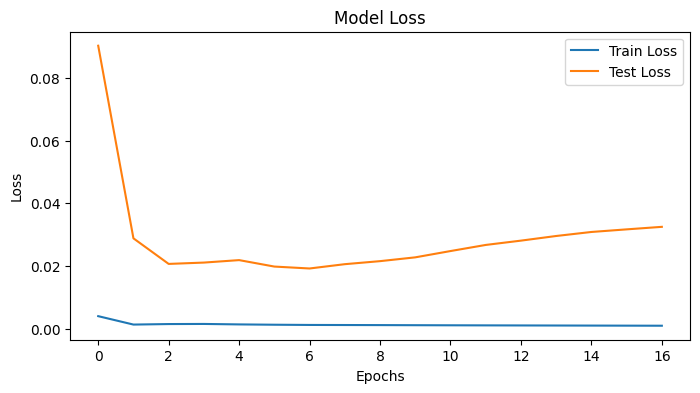

In [68]:
def model_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()

model_loss(history)

### Step 5. Visualizing Prediction

In [69]:
def prediction_plot(testY, test_predict, look_back):
    len_prediction = [x for x in range(len(testY)-look_back)]
    len_prediction = [int(x) for x in len_prediction]  
    plt.plot(len_prediction, testY[:len(len_prediction)], marker='.', label="Actual")
    plt.plot(len_prediction, test_predict[:len(len_prediction)], 'r', label="Prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time Step', size=15)
    plt.legend(fontsize=15)
    plt.show()

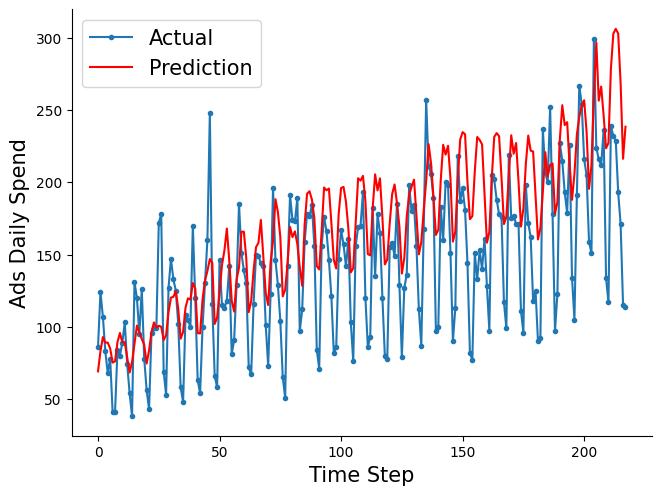

In [70]:
prediction_plot(testY, test_predict, look_back)